In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import text_dataset_from_directory

### Reding the data

In [2]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearning-SETs/aclImdb/')

In [3]:
tr_d = text_dataset_from_directory( w_dir / 'train' )
va_d = text_dataset_from_directory( w_dir / 'validation' )
te_d = text_dataset_from_directory( w_dir / 'test' )

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
# getting a sequence of int
text_vectorization = layers.TextVectorization(
    max_tokens=20000,
    output_mode='int',
    output_sequence_length=600
)

In [5]:
text_only = tr_d.map( lambda x, y: x )

text_vectorization.adapt( text_only )

In [6]:
tr_d_int = tr_d.map( lambda x, y: ( text_vectorization(x), y ), num_parallel_calls=tf.data.AUTOTUNE )
va_d_int = va_d.map( lambda x, y: ( text_vectorization(x), y ), num_parallel_calls=tf.data.AUTOTUNE )
te_d_int = te_d.map( lambda x, y: ( text_vectorization(x), y ), num_parallel_calls=tf.data.AUTOTUNE )

In [7]:
tr_d_int = tr_d_int.prefetch( buffer_size=tf.data.AUTOTUNE )
va_d_int = va_d_int.prefetch( buffer_size=tf.data.AUTOTUNE )
te_d_int = te_d_int.prefetch( buffer_size=tf.data.AUTOTUNE )

### The transformer encoder as a subclaseed layer

In [8]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        
        super().__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation='relu'),
                layers.Dense(dense_dim)
            ]
        )
        
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        
    def call(self, inputs, mask=None):
        
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
            
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj( proj_input )
        
        proj_input32 = self.dense_proj( proj_input )
        
        return self.layernorm_2(proj_input32 + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'embed_dim': self.embed_dim,
                'num_heads': self.num_heads,
                'dense_dim': self.dense_dim
            }
        )
        
        return config

In [24]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        position = tf.range(start=0, limit=length, delta=1)
        
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(position)
        
        return embedded_tokens + embedded_positions
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        
        config.update(
            {
                'input_dim':self.input_dim,
                'output_dim':self.output_dim,
                'sequence_length':self.sequence_length
            }
        )
        
        return config

### The Model

In [13]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32
sequence_length = 600

In [10]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [25]:
with strategy.scope():
    inputs = keras.Input(shape=(None,), dtype='int64')
    
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)   
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'TransformerEncoder.keras',
        save_best_only=True,
        monitor='accuracy'
    ),
    keras.callbacks.TensorBoard(
        log_dir='TensorBoard_Logs/'
    )
]

history = model.fit(
    tr_d_int,
    epochs=25,
    validation_data=va_d_int,
    callbacks=callbacks
)

Epoch 1/25
625/625 [==============================] - 98s 149ms/step - loss: 0.4966 - accuracy: 0.7646 - val_loss: 0.3185 - val_accuracy: 0.8616
Epoch 2/25
625/625 [==============================] - 65s 103ms/step - loss: 0.3015 - accuracy: 0.8789 - val_loss: 0.2948 - val_accuracy: 0.8780
Epoch 3/25
625/625 [==============================] - 52s 83ms/step - loss: 0.2423 - accuracy: 0.9055 - val_loss: 0.3243 - val_accuracy: 0.8582
Epoch 4/25
625/625 [==============================] - 50s 80ms/step - loss: 0.2041 - accuracy: 0.9232 - val_loss: 0.2827 - val_accuracy: 0.8838
Epoch 5/25
625/625 [==============================] - 47s 76ms/step - loss: 0.1775 - accuracy: 0.9342 - val_loss: 0.3408 - val_accuracy: 0.8808
Epoch 6/25
625/625 [==============================] - 47s 76ms/step - loss: 0.1576 - accuracy: 0.9416 - val_loss: 0.6426 - val_accuracy: 0.8234
Epoch 7/25
625/625 [==============================] - 48s 76ms/step - loss: 0.1403 - accuracy: 0.9492 - val_loss: 0.3780 - val_accurac

In [29]:
test_model = keras.models.load_model(
    'TransformerEncoder.keras',
    custom_objects={
        'TransformerEncoder':TransformerEncoder,
        'PositionalEmbedding':PositionalEmbedding
    }
)

print(f"Test acc: {test_model.evaluate(te_d_int)[1]:.3f}")

782/782 [==============================] - 30s 38ms/step - loss: 1.2888 - accuracy: 0.8509
Test acc: 0.851


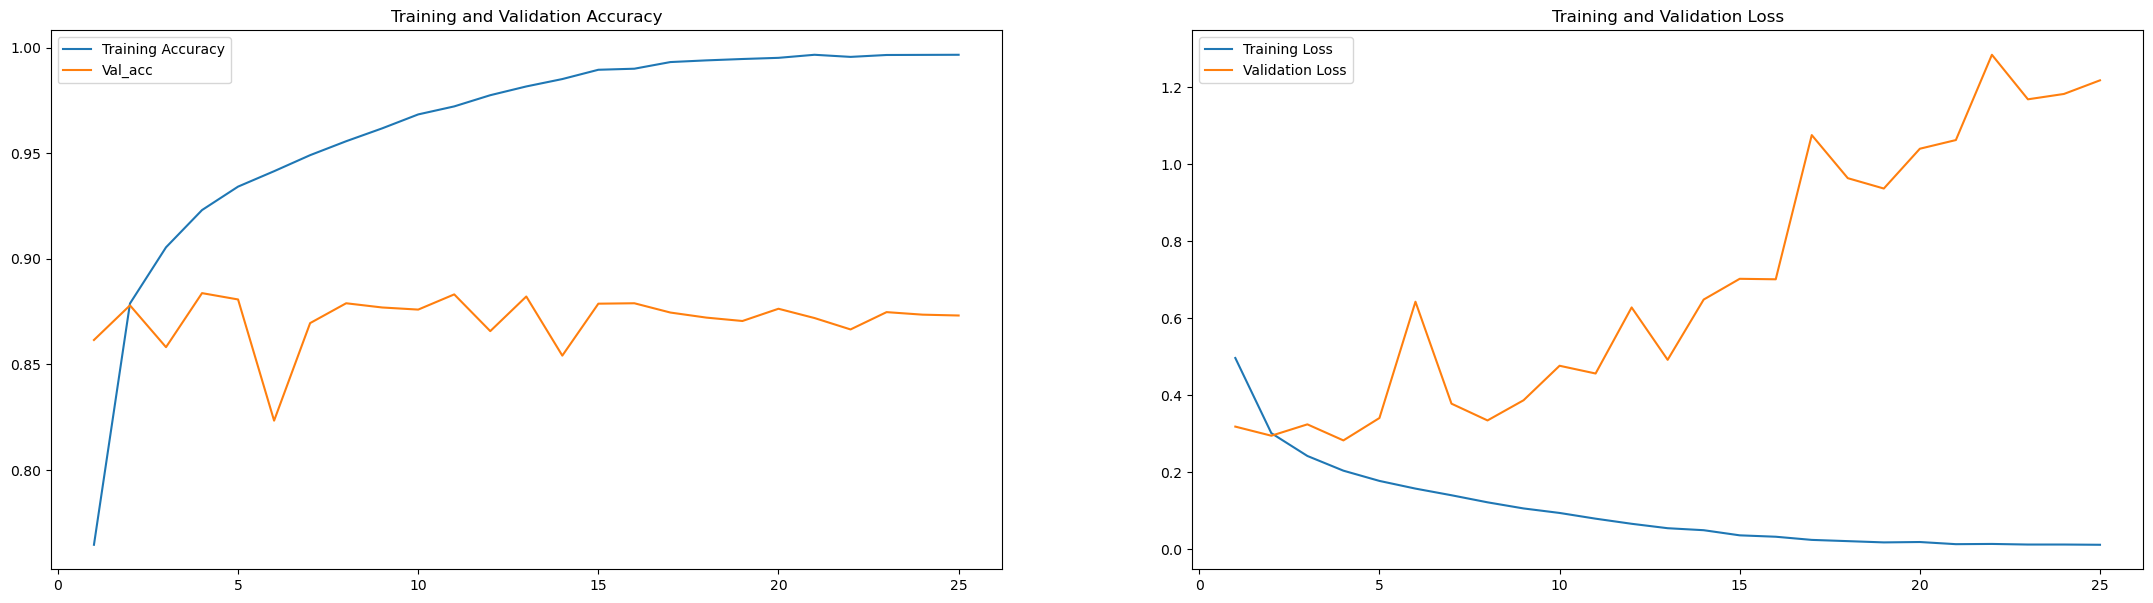

In [33]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range( 1, len(accuracy) + 1 )

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(27,7))

ax[0].plot(epochs, accuracy, label='Training Accuracy')
ax[0].plot(epochs, val_acc, label='Val_acc')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, label='Training Loss')
ax[1].plot(epochs, val_loss, label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend();